In [1]:
# import packages
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from scipy.stats import ttest_ind
import statsmodels.stats.multitest as smm
from adjustText import adjust_text
import os

from statannotations.Annotator import Annotator

In [3]:
# Load data 
output_dir = '../../../LCMS/'

# Load the Excel file
excel_file = os.path.join(output_dir, '7689.SUB15127_MetabolomicsData_Targeted.xlsx')

# Load the sheet into a DataFrame
sheet_name = 'Untargeted'  # Replace with the actual sheet name if different
data = pd.read_excel(excel_file, sheet_name=sheet_name)
metadata = pd.read_excel(excel_file, sheet_name='SamplesNames')

/Users/djuna/Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


In [4]:
# Are there any annotations based on the blank used for background subtraction?

# I don't see any extraction blank columns so we don't have to check for higher signal in the non-blanks vs the blanks
'Background' in set(data.iloc[:,2].unique())


False

In [5]:
set(data.iloc[:,2].unique())

{'Bad integration;Level 1 ID',
 'Bad integration;Level 2 ID',
 'FISHhit',
 'FISHhit;Top PLS compound',
 'Level 1 ID',
 'Level 2 ID',
 'MasslistRT ID',
 'Other ID',
 'Other ID;Top PLS compound',
 'Tags',
 'Tags\nImportant, please read report',
 'Top PLS compound',
 'Weak/poor match',
 'Weak/poor match;Bad integration',
 nan}

In [6]:
# get metadata
meta = metadata.iloc[2:]
meta.columns = metadata.iloc[1]
meta['grp'] = meta['Line'] + '_' + meta['Treatment']
dictionary = dict(zip(meta['CD file'], meta['grp']))
dictionary_outliers = dict(zip(meta['CD file'], meta['Exp']))

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_46047/2743206479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta['grp'] = meta['Line'] + '_' + meta['Treatment']


In [7]:
# get the normalized areas
norm_areas = data.iloc[6:,64:95]
norm_areas.columns = [x.split('(')[1].split(')')[0] for x in norm_areas.iloc[0].values]
norm_areas = norm_areas[1:]
norm_areas.index = np.arange(len(norm_areas))
names = np.array([dictionary[x] for x in norm_areas.columns])
outliers = np.array([dictionary_outliers[x] for x in norm_areas.columns])

In [8]:
# remove the outliers
norm_areas_no_outliers = norm_areas.iloc[:,outliers!='outlier']
names_no_outliers = names[outliers!='outlier']
outliers_no_outliers = outliers[outliers!='outlier']

In [162]:
names_no_outliers

array(['E3_H2O', 'E3_H2O', 'E3_H2O', 'E3_H2O', 'E3_H2O', 'E3_H2O',
       'E3_H2O', 'E3_H2O', 'E3_H2O', 'G2_H2O', 'G2_H2O', 'G2_H2O',
       'G2_H2O', 'G2_H2O', 'Y_C', 'Y_C', 'Y_C', 'Y_C', 'Y_C', 'Y_C',
       'Y_C', 'Y_H2O', 'Y_H2O', 'Y_H2O', 'Y_H2O', 'Y_H2O', 'Y_H2O',
       'Y_H2O'], dtype='<U6')

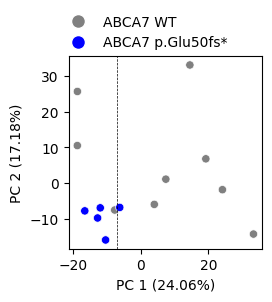

In [163]:
# only look at E3 vs G2
names_subset = np.where((names_no_outliers!='Y_H2O') & (names_no_outliers!='Y_C'))[0]
norm_areas_subset = norm_areas_no_outliers.iloc[:,names_subset]
names_subset = names_no_outliers[names_subset]

# perform PCA
scaler = StandardScaler()
norm_areas_subset_no_background_scaled = scaler.fit_transform(norm_areas_subset.T)

pca = PCA(n_components=4)
principal_components = pca.fit_transform(norm_areas_subset_no_background_scaled)
principal_components = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4'])
principal_components['condition'] = names_subset

# plot PCA
plt.figure(figsize=(2.5, 2.5))
palette = {'E3_H2O': 'grey', 'Y_H2O': 'orange', 'Y_C': 'purple', 'G2_H2O': 'blue'}
sns.scatterplot(x='PC1', y='PC2', hue='condition', data=principal_components, palette=palette, edgecolor='w')
explained_variance = pca.explained_variance_ratio_
plt.xlabel(f'PC 1 ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'PC 2 ({explained_variance[1]*100:.2f}%)')
plt.legend(title='Line', bbox_to_anchor=(1.05, 1), loc='upper left')
# Remove the existing legend
plt.legend([],[], frameon=False)

# Add a custom legend based on marker type
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor='grey', markersize=10,linestyle='None', label='ABCA7 WT'),
    Line2D([0], [0], marker='o', markerfacecolor='blue',color='w',
           markersize=10, linestyle='None', label='ABCA7 p.Glu50fs*')
]
plt.legend(handles=legend_elements, title='', bbox_to_anchor=(.4, 1.28), loc='upper center', frameon=False)
# Add vertical line along the mean of PC1
mean_pc1 = principal_components['PC1'].median()
plt.axvline(x=mean_pc1, color='black', linestyle='--',  linewidth=0.5)



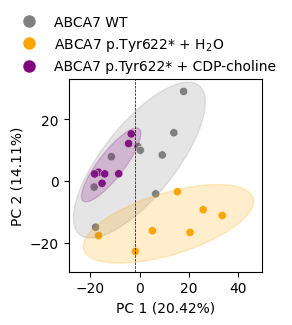

In [18]:
# only look at E3, Y, YC
names_subset = np.where((names_no_outliers!='G2_H2O'))[0]
norm_areas_subset = norm_areas_no_outliers.iloc[:,names_subset]
names_subset = names_no_outliers[names_subset]

# perform PCA
scaler = StandardScaler()
norm_areas_subset_no_background_scaled = scaler.fit_transform(norm_areas_subset.T)

pca = PCA(n_components=4)
principal_components = pca.fit_transform(norm_areas_subset_no_background_scaled)
principal_components = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4'])
principal_components['condition'] = names_subset

# plot PCA
plt.figure(figsize=(2.5, 2.5))
palette = {'E3_H2O': 'grey', 'Y_H2O': 'orange', 'Y_C': 'purple', 'G2_H2O': 'blue'}
sns.scatterplot(x='PC1', y='PC2', hue='condition', data=principal_components, palette=palette, edgecolor='w')
explained_variance = pca.explained_variance_ratio_
plt.xlabel(f'PC 1 ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'PC 2 ({explained_variance[1]*100:.2f}%)')
plt.legend(title='Line', bbox_to_anchor=(1.05, 1), loc='upper left')
# Remove the existing legend
plt.legend([],[], frameon=False)

import matplotlib.patches as patches
for treatment in principal_components['condition'].unique():
    line_data = principal_components[principal_components['condition'] == treatment]
    confidence_ellipse = np.cov(line_data['PC1'], line_data['PC2'])
    eigenvals, eigenvecs = np.linalg.eig(confidence_ellipse)
    angle = np.degrees(np.arctan2(eigenvecs[1,0], eigenvecs[0,0]))
    
    ellipse = patches.Ellipse(xy=(line_data['PC1'].mean(), line_data['PC2'].mean()),
                            width=2*np.sqrt(eigenvals[0])*2,
                            height=2*np.sqrt(eigenvals[1])*2,
                            angle=angle,
                            fill=True,
                            alpha=0.2,
                            color=palette[treatment])
    plt.gca().add_patch(ellipse)

explained_variance = pca.explained_variance_ratio_
plt.xlabel(f'PC 1 ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'PC 2 ({explained_variance[1]*100:.2f}%)')
plt.legend(title='Line', bbox_to_anchor=(1.05, 1), loc='upper left')
# Remove the existing legend
plt.legend([],[], frameon=False)

# Add a custom legend based on marker type
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor='grey', markersize=10,linestyle='None', label='ABCA7 WT'),
           
           Line2D([0], [0], marker='o', markerfacecolor='orange',color='w',
           markersize=10, linestyle='None', label='ABCA7 p.Tyr622* + H$_2$O'),
           Line2D([0], [0], marker='o', markerfacecolor='purple',color='w',
           markersize=10, linestyle='None', label='ABCA7 p.Tyr622* + CDP-choline')
]
plt.legend(handles=legend_elements, title='', bbox_to_anchor=(.4, 1.4), loc='upper center', frameon=False)
# Add vertical line along the mean of PC1
mean_pc1 = principal_components['PC1'].median()
plt.axvline(x=mean_pc1, color='black', linestyle='--',  linewidth=0.5)

plt.savefig('../../../paper/main_plots/pca_plot_y622_choline_metab.png', bbox_inches='tight')



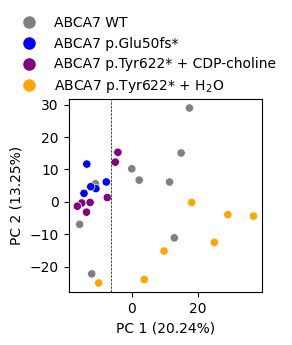

In [165]:
# show all
norm_areas_subset = norm_areas_no_outliers#.iloc[:,names_subset]
names_subset = names_no_outliers#[names_subset]

# perform PCA
scaler = StandardScaler()
norm_areas_subset_no_background_scaled = scaler.fit_transform(norm_areas_subset.T)

pca = PCA(n_components=4)
principal_components = pca.fit_transform(norm_areas_subset_no_background_scaled)
principal_components = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4'])
principal_components['condition'] = names_subset

# plot PCA
plt.figure(figsize=(2.5, 2.5))
palette = {'E3_H2O': 'grey', 'Y_H2O': 'orange', 'Y_C': 'purple', 'G2_H2O': 'blue'}
sns.scatterplot(x='PC1', y='PC2', hue='condition', data=principal_components, palette=palette, edgecolor='w')
explained_variance = pca.explained_variance_ratio_
plt.xlabel(f'PC 1 ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'PC 2 ({explained_variance[1]*100:.2f}%)')
plt.legend(title='Line', bbox_to_anchor=(1.05, 1), loc='upper left')
# Remove the existing legend
plt.legend([],[], frameon=False)

# Add a custom legend based on marker type
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor='grey', markersize=10,linestyle='None', label='ABCA7 WT'),
    Line2D([0], [0], marker='o', markerfacecolor='blue',color='w',
           markersize=10, linestyle='None', label='ABCA7 p.Glu50fs*'),
           Line2D([0], [0], marker='o', markerfacecolor='purple',color='w',
           markersize=10, linestyle='None', label='ABCA7 p.Tyr622* + CDP-choline'),
           Line2D([0], [0], marker='o', markerfacecolor='orange',color='w',
           markersize=10, linestyle='None', label='ABCA7 p.Tyr622* + H$_2$O'),
]
plt.legend(handles=legend_elements, title='', bbox_to_anchor=(.4, 1.5), loc='upper center', frameon=False)
# Add vertical line along the mean of PC1
mean_pc1 = principal_components['PC1'].median()
plt.axvline(x=mean_pc1, color='black', linestyle='--',  linewidth=0.5)



In [166]:
# get stats data
names = np.array(data.iloc[7:,1])
tags = np.array(data.iloc[7:,2])

N = data.iloc[6,21:33]
metab_stats = data.iloc[7:,21:33]
metab_stats.columns = N

In [101]:
metab_stats['names'] = names
metab_stats['tags'] = tags

# get choline stats
def return_stats(metab_stats, p_col, lfc_col, group):
    _, fdr_corrected_pvals, _, _ = smm.multipletests(metab_stats[p_col], alpha=0.05, method='fdr_bh')
    return {group: {'FDR': fdr_corrected_pvals.astype(float), 'LFC': metab_stats[lfc_col].values.astype(float)}}

def get_significant_metabolites(combined_stats, group):
    sig_indices = ((combined_stats[group]['FDR']<0.05) & (np.abs(combined_stats[group]['LFC'])>1))
    names_selected = names[sig_indices]
    tags_selected = tags[sig_indices]
    return names_selected[np.array([x in set(['Level 2 ID', 'Level 1 ID']) for x in tags_selected])]


In [167]:
y622_choline_stats = return_stats(metab_stats, 'P-value: (Exp1, Y, C) / (Exp1, Y, H2O)', 'Log2 Fold Change: (Exp1, Y, C) / (Exp1, Y, H2O)', 'Y_C')
y622_h2o_stats = return_stats(metab_stats, 'P-value: (Exp1, E3, H2O) / (Exp1, Y, H2O)', 'Log2 Fold Change: (Exp1, E3, H2O) / (Exp1, Y, H2O)', 'Y_H2O')
g2_stats = return_stats(metab_stats, 'P-value: (Exp1, G2, H2O) / (Exp1, E3, H2O)', 'Log2 Fold Change: (Exp1, G2, H2O) / (Exp1, E3, H2O)', 'G2')

In [168]:
combined_stats = {**y622_choline_stats, **y622_h2o_stats, **g2_stats}
combined_stats

{'Y_C': {'FDR': array([0.03762612, 0.99999943, 0.79425868, ..., 0.99999943, 0.99999943,
         0.41091655]),
  'LFC': array([-2.87,  1.44,  1.73, ...,  0.7 , -0.51, -1.51])},
 'Y_H2O': {'FDR': array([0.2272139 , 0.99999998, 0.99999998, ..., 0.99999998, 0.99999998,
         0.77017917]),
  'LFC': array([-2.18, -3.87, -0.03, ...,  1.24,  0.23, -0.82])},
 'G2': {'FDR': array([1.        , 1.        , 0.87943445, ..., 1.        , 0.24334299,
         1.        ]),
  'LFC': array([-0.85,  1.12,  1.32, ..., -0.59, -1.69, -0.87])}}

In [169]:
for group in ['Y_C', 'Y_H2O', 'G2']:
    print(group + ' has ' + str(np.sum((combined_stats[group]['FDR']<0.05) & (np.abs(combined_stats[group]['LFC'])>1))) + ' significant metabolites')

Y_C has 164 significant metabolites
Y_H2O has 132 significant metabolites
G2 has 11 significant metabolites


In [171]:
get_significant_metabolites(combined_stats, 'Y_C')

array(['Triisopropanolamine', 'Iditol or other sugar alchohol', 'choline'],
      dtype=object)

In [172]:
get_significant_metabolites(combined_stats, 'Y_H2O')


array(['N-Acetyl-1-aspartylglutamic acid', 'Melamine', 'Inositol',
       'choline'], dtype=object)

In [227]:
combined_stats['Y_H2O']['LFC'][names=='Inositol']

array([-1.9])

In [173]:
get_significant_metabolites(combined_stats, 'G2')

array([], dtype=object)

In [194]:
D = dict(zip(metadata['Unnamed: 0'], metadata['Unnamed: 1']))

In [197]:
temp = norm_areas_no_outliers[names=='choline'].iloc[:,names_no_outliers!='G2_H20']
temp.columns = [D[x] for x in temp.columns]

In [200]:
temp.T.sort_index()

,58
SUB15127p7_SPL02,159593.593288
SUB15127p7_SPL03,207733.802934
SUB15127p7_SPL04,8049155.896197
SUB15127p7_SPL05,11102856.215294
SUB15127p7_SPL06,11759336.976469
SUB15127p7_SPL07,287480.753349
SUB15127p7_SPL08,54146396.825699
SUB15127p7_SPL09,44299502.933666
SUB15127p7_SPL11,74296337.698628
SUB15127p7_SPL12,11173843.216661


In [223]:
scores_Y_C = (combined_stats['Y_C']['LFC'])# * -np.log10(combined_stats['Y_C']['FDR'])
scores_Y_H2O = -1*(combined_stats['Y_H2O']['LFC']) #* -np.log10(combined_stats['Y_H2O']['FDR'])
scores_G2 = (combined_stats['G2']['LFC'])# * -np.log10(combined_stats['G2']['FDR'])
df = pd.DataFrame(np.vstack((scores_Y_C, scores_Y_H2O, scores_G2)).T)
df.columns = ['Y_C', 'Y_H2O', 'G2']
df
# show correlation of scores between CDP-choline and LoF metabolite fold changes

,Y_C,Y_H2O,G2
0,-2.87,2.18,-0.85
1,1.44,3.87,1.12
2,1.73,0.03,1.32
3,0.04,-0.32,-0.28
4,-0.86,1.64,0.94
...,...,...,...
1129,0.64,-0.97,-0.38
1130,-1.07,0.02,-1.18
1131,0.70,-1.24,-0.59
1132,-0.51,-0.23,-1.69


In [221]:
np.where(names=='choline')

(array([58]),)

In [228]:
df.shape

(1134, 3)

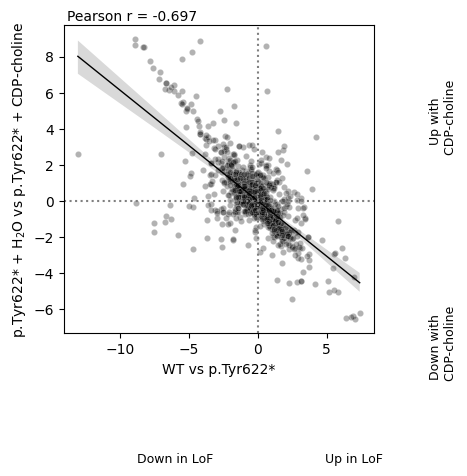

In [218]:
# show correlation of scores between CDP-choline and LoF metabolite fold changes

from scipy import stats

plt.figure(figsize=(4, 4))
# Plot the regression line using the full dataset without scatter points
sns.regplot(x='Y_C', y='Y_H2O', data=df, scatter=False, ci=95, color='black', line_kws={'linewidth': 1})
# Overlay scatter points from the subsample
sns.scatterplot(x='Y_C', y='Y_H2O', data=df, color='black', alpha=0.3, s=20)
# Calculate Pearson correlation coefficient and p-value
r, p = stats.pearsonr(df['Y_C'], df['Y_H2O'])

# Add text annotation with the correlation coefficient
plt.text(0.01, 1.05, f'Pearson r = {r:.3f}',
         transform=plt.gca().transAxes, verticalalignment='top')

# Add horizontal and vertical dotted lines at zero
plt.axhline(y=0, color='grey', linestyle='dotted')
plt.axvline(x=0, color='grey', linestyle='dotted')

plt.xlabel('WT vs p.Tyr622*')
plt.ylabel('p.Tyr622* + H$_2$O vs p.Tyr622* + CDP-choline')
# Add arrow in lower right quadrant
plt.annotate('', xy=(14, -14), xytext=(10, -14),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(7, -14.5, 'Up in LoF', ha='center', fontsize=9)

plt.annotate('', xy=(-14, -14), xytext=(-10, -14),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(-6, -14.5, 'Down in LoF', ha='center', fontsize=9)

plt.annotate('', xy=(14, 14), xytext=(14, 10),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(13.5, 2.5, 'Up with \n CDP-choline', ha='center', fontsize=9, rotation=90)

plt.annotate('', xy=(14, -14), xytext=(14, -10),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(13.5, -10, 'Down with \n CDP-choline', ha='center', fontsize=9, rotation=90)


#plt.xlim(-15, 15)
#plt.ylim(-15, 15)
#plt.savefig('../../paper/main_plots/rna_correlation_plot.png', bbox_inches='tight')

plt.show()
